In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import nltk
import sklearn
import nltk.collocations 
from nltk import FreqDist, word_tokenize
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV
import string, re
import urllib
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from nltk.stem import WordNetLemmatizer
from nltk.stem.snowball import SnowballStemmer
from nltk.corpus import stopwords
from sklearn.decomposition import PCA
from sklearn.naive_bayes import MultinomialNB, GaussianNB
from sklearn.model_selection import cross_validate
from sklearn import svm
from sklearn.pipeline import Pipeline
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import SGDClassifier

In [20]:
nltk.download('words')
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package words to
[nltk_data]     C:\Users\lidij\AppData\Roaming\nltk_data...
[nltk_data]   Package words is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\lidij\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\lidij\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [2]:
local_path = 'clean_data.csv'
df = pd.read_csv(local_path, index_col=0)
df.head()

,song,year,artist,genre,lyrics,word_count
0,No Broken Hearted Girl,2009,beyonce-knowles,Pop,Youre everything I thought you never were\nAnd...,468
1,Standing On The Sun,2013,beyonce-knowles,Pop,My body is magnified\nIn the sun set me alight...,421
2,Rise Up,2013,beyonce-knowles,Pop,I'm the matriarch of your land OH\nWhen you ne...,341
3,Jealous,2013,beyonce-knowles,Pop,[Verse 1]\nI'm in my penthouse half naked\nI c...,264
4,Everything I Do,2006,beyonce-knowles,Pop,Every step I make\nAnd every breath I take\nI ...,281


### Lyrics preprocessing

In [3]:
def clean_lyrics(lyrics_list, lemma=True):
    
    cleaned = []
    pattern = "([a-zA-Z]+(?:'[a-z]+)?)"
    english = list(set(nltk.corpus.words.words()))
    
    if lemma == True:
        lemmatizer = WordNetLemmatizer()
    else:
        stemmer = SnowballStemmer("english")
    
    for lyric in lyrics_list:
        clean_lyric = nltk.regexp_tokenize(lyric, pattern)
        lyric_lower = [i.lower() for i in clean_lyric]
        stop_words = stopwords.words('english')
        stopwords_list = stop_words + list(string.punctuation) + ["''", '""', '...', '``']
#         stopwords_list += ["''", '""', '...', '``']
        lyrics_tokens_stopped = [w for w in lyric_lower if not w in stopwords_list]
        if lemma == True:
            lyric_lemmas = [lemmatizer.lemmatize(word) for word in lyrics_tokens_stopped]
            c = " ".join(lyric_lemmas)
            cleaned.append(c)
        else:
            lyric_stemmas = [stemmer.stem(word) for word in lyrics_tokens_stopped]
            c = " ".join(lyric_stemmas)
            cleaned.append(c)
            
    return cleaned

### Lemmatizing vs Stemmatizing

In [4]:
# lemmatized_lyrics = clean_lyrics(list(df.lyrics))
stemmed_lyrics = clean_lyrics(list(df.lyrics), lemma=False)

In [26]:
len(set(nltk.word_tokenize(" ".join(stemmed_lyrics))))

48542

In [53]:
len(set(nltk.word_tokenize(" ".join(lemmatized_lyrics))))

61330

In [61]:
def classify(X, y=df.genre):

    pipe_NB = Pipeline([('count_vectorizer', CountVectorizer()), 
                         ('tfidf_vectorizer', TfidfTransformer()),
                         ('clf', MultinomialNB())
                        ])

    pipe_GBoost = Pipeline([('count_vectorizer', CountVectorizer()), 
                         ('tfidf_vectorizer', TfidfTransformer()),
                         ('clf', GradientBoostingClassifier(learning_rate=0.3))
                        ])

    pipe_RF = Pipeline([('count_vectorizer', CountVectorizer()), 
                         ('tfidf_vectorizer', TfidfTransformer()),
                         ('clf', RandomForestClassifier())
                        ])

    pipe_ADA = Pipeline([('count_vectorizer', CountVectorizer()), 
                         ('tfidf_vectorizer', TfidfTransformer()),
                         ('clf', AdaBoostClassifier(learning_rate=0.3))
                        ])

    pipe_KNN = Pipeline([('count_vectorizer', CountVectorizer()), 
                         ('tfidf_vectorizer', TfidfTransformer()),
                         ('clf', KNeighborsClassifier())
                        ])

    pipe_SGD = Pipeline([('count_vectorizer', CountVectorizer()),
                        ('tfidf_vectorizer', TfidfTransformer()),
                        ('clf', SGDClassifier(loss='hinge', penalty='l2',alpha=1e-3, random_state=42, max_iter=5, tol=None)),
                       ])
    pipe_SVM = Pipeline([('count_vectorizer', CountVectorizer()),
                        ('tfidf_vectorizer', TfidfTransformer()),
                        ('clf', svm.SVC(kernel='linear'))])

    pipelines = [pipe_NB, pipe_GBoost, pipe_RF, pipe_ADA, pipe_KNN, pipe_SGD, pipe_SVM]
    pipeline_names = ['Multinomial NB', "Gboost", 'Random Forest', 'ADA', "KNN", "SGD", "SVM"]
    scores = dict.fromkeys(pipeline_names, 0)
    scoring = ['f1_micro', 'f1_macro', 'precision_macro', 'recall_macro']

    for pipe, name in zip(pipelines, pipeline_names):
        print(pipe)
        score = cross_validate(pipe, X, y, cv=5, scoring=scoring)
        scores[name] = score
        print('%s pipeline test accuracy: %.3f, f1_macro: %.3f' % (name, scores[name]['test_f1_micro'].mean(), 
                                                                    scores[name]['test_f1_macro'].mean()))
    return scores

In [62]:
scores_stem = classify(stemmed_lyrics)

Pipeline(memory=None,
         steps=[('count_vectorizer',
                 CountVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.int64'>, encoding='utf-8',
                                 input='content', lowercase=True, max_df=1.0,
                                 max_features=None, min_df=1,
                                 ngram_range=(1, 1), preprocessor=None,
                                 stop_words=None, strip_accents=None,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=None, vocabulary=None)),
                ('tfidf_vectorizer',
                 TfidfTransformer(norm='l2', smooth_idf=True,
                                  sublinear_tf=False, use_idf=True)),
                ('clf',
                 MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True))],
         verbose=False)
Multinomial NB pipeline tes

C:\Users\lidij\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\lidij\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\lidij\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\lidij\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.2

Random Forest pipeline test accuracy: 0.348, f1_macro: 0.336
Pipeline(memory=None,
         steps=[('count_vectorizer',
                 CountVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.int64'>, encoding='utf-8',
                                 input='content', lowercase=True, max_df=1.0,
                                 max_features=None, min_df=1,
                                 ngram_range=(1, 1), preprocessor=None,
                                 stop_words=None, strip_accents=None,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=None, vocabulary=None)),
                ('tfidf_vectorizer',
                 TfidfTransformer(norm='l2', smooth_idf=True,
                                  sublinear_tf=False, use_idf=True)),
                ('clf',
                 AdaBoostClassifier(algorithm='SAMME.R', base_estimat

In [134]:
for (key, val) in scores_stem.items():
    for (k, v) in val.items():
        a = v.mean()
        val[k] = a

In [135]:
scores_stem

{'Multinomial NB': {'fit_time': 2.5699784755706787,
  'score_time': 2.4786211490631103,
  'test_f1_micro': 0.4306835637480798,
  'test_f1_macro': 0.39176256844996127,
  'test_precision_macro': 0.43014869732299915,
  'test_recall_macro': 0.4306835637480798},
 'Gboost': {'fit_time': 447.0140353679657,
  'score_time': 2.8001992225646974,
  'test_f1_micro': 0.41390168970814134,
  'test_f1_macro': 0.4107132798499623,
  'test_precision_macro': 0.4104746193412561,
  'test_recall_macro': 0.41390168970814134},
 'Random Forest': {'fit_time': 12.163918828964233,
  'score_time': 2.679413604736328,
  'test_f1_micro': 0.34796466973886325,
  'test_f1_macro': 0.3360896421264515,
  'test_precision_macro': 0.3353933525656954,
  'test_recall_macro': 0.34796466973886325},
 'ADA': {'fit_time': 18.39857420921326,
  'score_time': 3.6190205097198485,
  'test_f1_micro': 0.3637480798771121,
  'test_f1_macro': 0.36553409258848213,
  'test_precision_macro': 0.38396708796540885,
  'test_recall_macro': 0.3637480798

In [63]:
scores_lem = classify(lemmatized_lyrics)

Pipeline(memory=None,
         steps=[('count_vectorizer',
                 CountVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.int64'>, encoding='utf-8',
                                 input='content', lowercase=True, max_df=1.0,
                                 max_features=None, min_df=1,
                                 ngram_range=(1, 1), preprocessor=None,
                                 stop_words=None, strip_accents=None,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=None, vocabulary=None)),
                ('tfidf_vectorizer',
                 TfidfTransformer(norm='l2', smooth_idf=True,
                                  sublinear_tf=False, use_idf=True)),
                ('clf',
                 MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True))],
         verbose=False)
Multinomial NB pipeline tes

C:\Users\lidij\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\lidij\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\lidij\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\lidij\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.2

Random Forest pipeline test accuracy: 0.349, f1_macro: 0.337
Pipeline(memory=None,
         steps=[('count_vectorizer',
                 CountVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.int64'>, encoding='utf-8',
                                 input='content', lowercase=True, max_df=1.0,
                                 max_features=None, min_df=1,
                                 ngram_range=(1, 1), preprocessor=None,
                                 stop_words=None, strip_accents=None,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=None, vocabulary=None)),
                ('tfidf_vectorizer',
                 TfidfTransformer(norm='l2', smooth_idf=True,
                                  sublinear_tf=False, use_idf=True)),
                ('clf',
                 AdaBoostClassifier(algorithm='SAMME.R', base_estimat

In [84]:
from matplotlib.ticker import MaxNLocator
from collections import namedtuple

def plot_results(metric='test_f1_micro'):

    models = list(scores.keys())
    accuracy_lem = [val[metric].mean() for (key, val) in scores_lem.items()]
    accuracy_stem = [val[metric].mean() for (key, val) in scores_stem.items()]
    # accuracy_lem = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7]
    # accuracy_stem = [0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8]

    fig, ax = plt.subplots(figsize = (14, 8))
    index = np.arange(len(models))
    bar_width = 0.3

    opacity = 0.5
    error_config = {'ecolor': '0.3'}

    lemmed_bars = ax.bar(index, accuracy_lem, bar_width,
                    alpha=opacity, color='b',
                    label='Lemmatized')

    stemmed_bars = ax.bar(index + bar_width, accuracy_stem, bar_width,
                    alpha=opacity, color='r',
                    label='Stemmed')

    ax.set_xlabel('Model', fontsize = 14)
    ax.set_ylabel('Accuracy', fontsize = 14)
    ax.set_title('Stemmed vs. Lemmatized ' + metric + ' comparison',  fontsize = 18)
    ax.set_xticks(index + bar_width / 2)
    ax.set_xticklabels(models)

    plt.axhline(y=0.125, color='#17CA83', linestyle='-', label = "Random Guessing")
    ax.legend()


    plt.show()

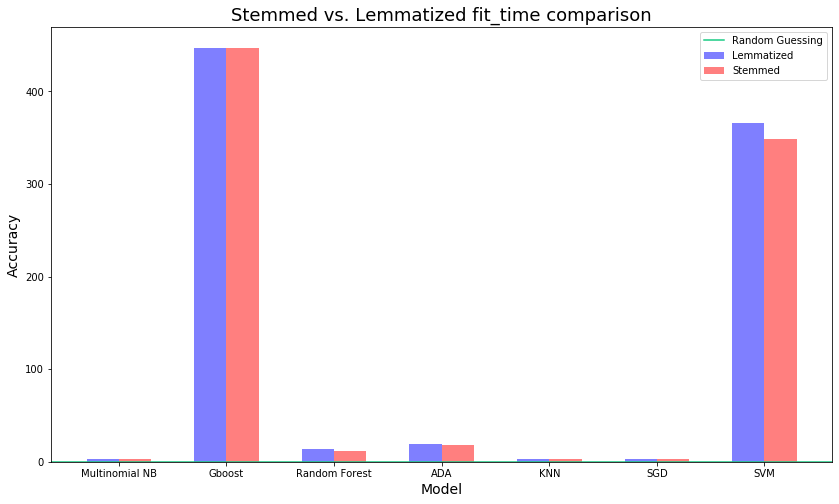

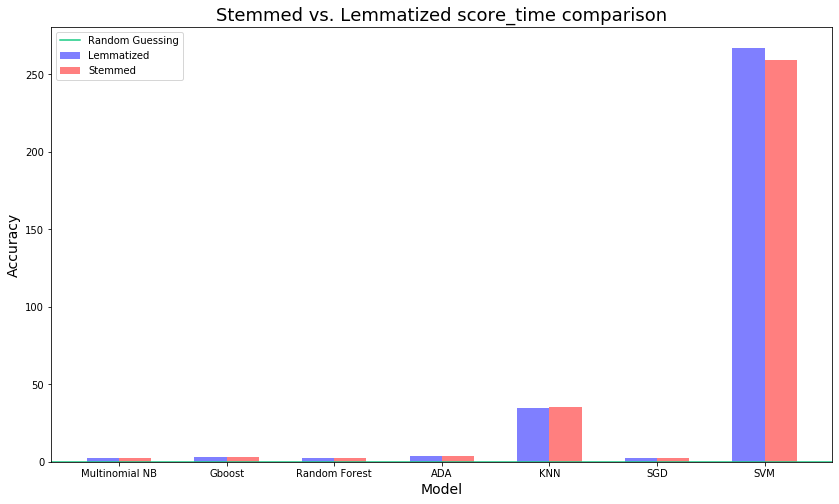

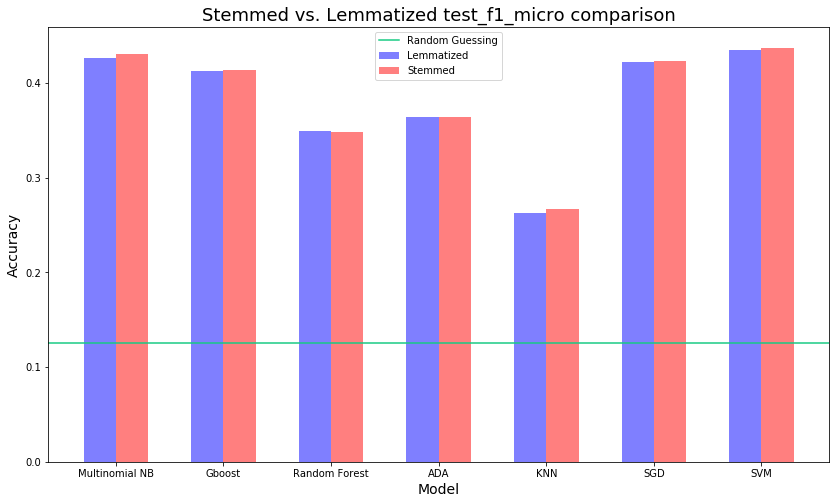

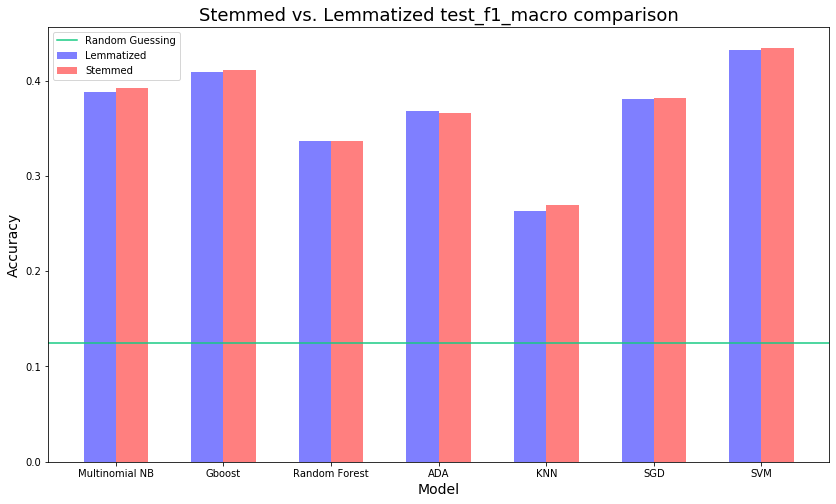

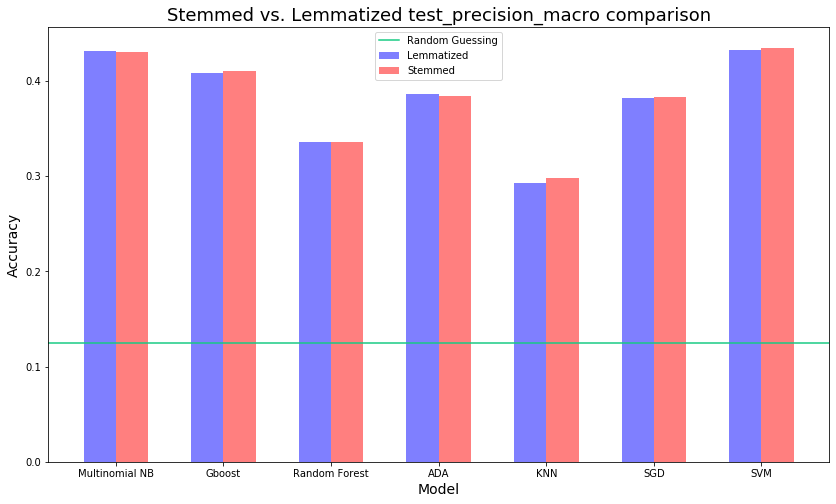

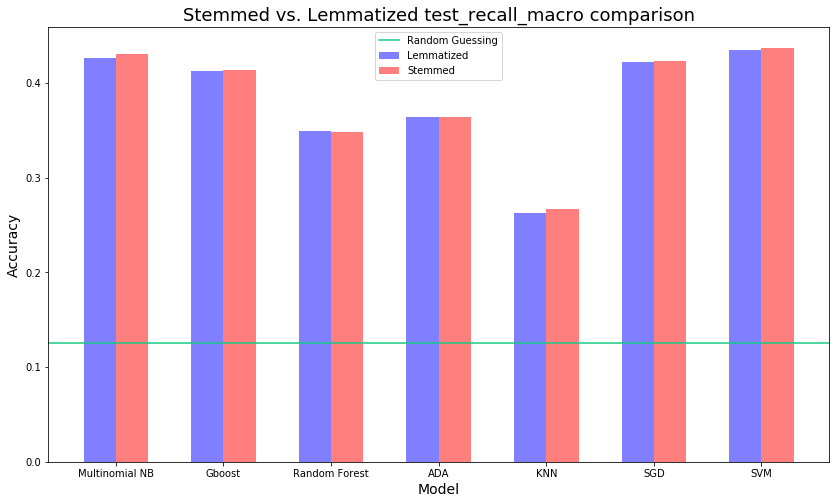

In [86]:
metrics = list(scores_lem['Multinomial NB'].keys())
for metric in metrics:
    plot_results(metric)

### We decided to pick Stemmed over Lemmatized and top three models for further optimization

1. SVM (0.437)
2. Multinomial NB (0.431)
3. GBoost (0.414)

### Next we want to try using PCA to improve performance and reduce dimentionality --> google colab

In [98]:
stemmed_df = pd.DataFrame(data=zip(stemmed_lyrics, df.genre.values), columns=['stemmed', 'genre'])
stemmed_df.to_csv('stemmed_for_pca.csv', encoding='utf-8')
stemmed_df.head()

,stemmed,genre
0,your everyth thought never noth like thought c...,Pop
1,bodi magnifi sun set alight bodi delight burn ...,Pop
2,i'm matriarch land oh need take hand come arm ...,Pop
3,vers i'm penthous half nake cook meal nake hel...,Pop
4,everi step make everi breath take took caus ca...,Pop


### Memory error here and in google colab, decide to drop the idea of using PCA

## Let's use GridSearch to try to optimize our  top 3 models!

In [5]:
X_train, X_test, y_train, y_test = train_test_split(stemmed_lyrics, df.genre, test_size=0.2, random_state=18) 

### Grid Search SGD

In [114]:
GS_pipe_SGD = Pipeline([('count_vectorizer', CountVectorizer()), 
                     ('tfidf_vectorizer', TfidfTransformer()),
                     ('clf', SGDClassifier()),
                    ])

# sorted(GS_pipe_SGD.get_params().keys())

SGD_param_grid = {
    'clf__alpha': [1e-4, 1e-3, 1e-2, 1e-1, 1e0, 1e1, 1e2, 1e3], # learning rate
    'clf__max_iter': [1000], # number of epochs
    'clf__loss': ['log'], # logistic regression,
    'clf__penalty': ['l2'],
    'clf__n_jobs': [-1]
}

gs_SGD = GridSearchCV(estimator=GS_pipe_SGD,
            param_grid=SGD_param_grid,
            scoring='accuracy',
            cv=3)

gs_SGD.fit(X_train, y_train)

GridSearchCV(cv=3, error_score='raise-deprecating',
             estimator=Pipeline(memory=None,
                                steps=[('count_vectorizer',
                                        CountVectorizer(analyzer='word',
                                                        binary=False,
                                                        decode_error='strict',
                                                        dtype=<class 'numpy.int64'>,
                                                        encoding='utf-8',
                                                        input='content',
                                                        lowercase=True,
                                                        max_df=1.0,
                                                        max_features=None,
                                                        min_df=1,
                                                        ngram_range=(1, 1),
                                

In [115]:
gs_SGD.cv_results_

{'mean_fit_time': array([2.05449263, 1.97333845, 1.92829903, 2.81365498, 2.28097471,
        2.26965253, 1.89797902, 1.8279899 ]),
 'std_fit_time': array([0.10391731, 0.11728275, 0.04398837, 0.54753551, 0.32593393,
        0.62465241, 0.08045169, 0.04674768]),
 'mean_score_time': array([0.90052732, 0.89001934, 0.84202425, 1.28751524, 1.05101236,
        0.86802332, 0.84701943, 0.85767913]),
 'std_score_time': array([0.04512575, 0.02556677, 0.02571455, 0.34046754, 0.27224251,
        0.01434733, 0.01203427, 0.02034747]),
 'param_clf__alpha': masked_array(data=[0.0001, 0.001, 0.01, 0.1, 1.0, 10.0, 100.0, 1000.0],
              mask=[False, False, False, False, False, False, False, False],
        fill_value='?',
             dtype=object),
 'param_clf__loss': masked_array(data=['log', 'log', 'log', 'log', 'log', 'log', 'log', 'log'],
              mask=[False, False, False, False, False, False, False, False],
        fill_value='?',
             dtype=object),
 'param_clf__max_iter': mas

In [116]:
dt_gs_test_score = np.mean(gs_SGD.cv_results_['mean_test_score'])
dt_gs_testing_score = gs_SGD.score(X_test, y_test)

print("Mean Training Score: {:.4}%".format(dt_gs_test_score * 100))
print("Mean Testing Score: {:.4}%".format(dt_gs_testing_score * 100))
print("Best Parameter Combination Found During Grid Search: {}".format(gs_SGD.best_params_))

Mean Training Score: 26.99%
Mean Testing Score: 47.43%
Best Parameter Combination Found During Grid Search: {'clf__alpha': 0.0001, 'clf__loss': 'log', 'clf__max_iter': 1000, 'clf__n_jobs': -1, 'clf__penalty': 'l2'}


In [6]:
GS_pipe_GB = Pipeline([('count_vectorizer', CountVectorizer()), 
                     ('tfidf_vectorizer', TfidfTransformer()),
                     ('clf', GradientBoostingClassifier())
                    ])

GB_params = {
    "clf__learning_rate": [0.2, 0.25],
    "clf__min_samples_split": [4, 5],
    "clf__min_samples_leaf": [6],
    "clf__max_depth":[3],
    "clf__n_estimators":[100, 150]
    }

gs_GB = GridSearchCV(estimator=GS_pipe_GB,
            param_grid=GB_params,
            scoring='accuracy',
            cv=3)

gs_GB.fit(X_train, y_train)

dt_GB_test_score = np.mean(gs_GB.cv_results_['mean_test_score'])
dt_GB_testing_score = gs_GB.score(X_test, y_test)

print("Mean Test Score: {:.4}%".format(dt_GB_test_score * 100))
print("Mean Testing Score: {:.4}%".format(dt_GB_testing_score * 100))
print("Best Parameter Combination Found During Grid Search: {}".format(gs_GB.best_params_))

Mean Test Score: 43.99%
Mean Testing Score: 45.89%
Best Parameter Combination Found During Grid Search: {'clf__learning_rate': 0.25, 'clf__max_depth': 3, 'clf__min_samples_leaf': 6, 'clf__min_samples_split': 4, 'clf__n_estimators': 150}
